In [1]:
from autotst.reaction import *

In [2]:
rxn = AutoTST_Reaction("CC=C(C)C+[O]O_[CH2]C=C(C)C+OO", "H_Abstraction")

final_log_file = rxn.label + "_overall.log"

from ase.io.gaussian import *
optimized_ase_ts = read_gaussian_out(final_log_file)

rxn.ts.ase_ts = optimized_ase_ts
rxn.ts.update_from_ase_ts()


thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-Py/../RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/

In [3]:
rxn.reactant_mols

[<AutoTST Molecule "CC=C(C)C">, <AutoTST Molecule "[O]O">]

In [4]:
from cclib.io import ccread
log_file_info = ccread(final_log_file)

rxn.vibrations = zip(log_file_info.vibfreqs, log_file_info.vibdisps)

got_imaginary_frequency = False
for vib, displacements in rxn.vibrations:
    if vib < 0: # Finding the imaginary frequency
        got_imaginary_frequency = True
        post_vibration_ts = rxn.ts.ase_ts.copy() 
        post_vibration_ts.arrays["positions"] -= displacements
        
assert got_imaginary_frequency == True, "Did not find an imaginary frequency"
def percent_change(original,new):
    percent_change = (abs(new - original) / original) * 100
    return percent_change

results = []

for torsion in rxn.ts.torsions:
    i,j,k,l = torsion.indices
    before = rxn.ts.ase_ts.get_dihedral(i,j,k,l)
    after = post_vibration_ts.get_dihedral(i,j,k,l)
    results.append(["Tor", torsion.indices, torsion.reaction_center, percent_change(before, after)])
    
for angle in rxn.ts.angles:
    i,j,k = angle.indices
    before = rxn.ts.ase_ts.get_angle(i,j,k)
    after = post_vibration_ts.get_angle(i,j,k)
    results.append(["Ang", angle.indices, angle.reaction_center, percent_change(before, after)])

for bond in rxn.ts.bonds:
    i,j = bond.indices
    before = rxn.ts.ase_ts.get_distance(i,j)
    after = post_vibration_ts.get_distance(i,j)
    results.append(["Bond", bond.indices, bond.reaction_center, percent_change(before, after)])

results = pd.DataFrame(results)
results.columns = ["type", "index", "center", "percent_change"]

if (np.log10(((results[results.center == "Yes"].mean()))) > np.log10(((results[results.center != "Yes"].mean()))) + 1).all():
    print "Vibrational analysis was successful"
    print True

else:
    print "Cannot reasonably say that we have arrived at a TS through vibrational analysis.\nRunning an IRC calc."
    print False

        

Vibrational analysis was successful
True


In [5]:
from autotst.calculators.vibrational_analysis import *

In [6]:
vib = Vibrational_Analysis(rxn)
print vib.validate_ts()
vib

vibrational_analysis.py:148 validate_ts INFO Vibrational analysis was successful


True


<AutoTST Vibrational Analysis "CC=C(C)C+[O]O_[CH2]C=C(C)C+OO">

In [7]:
from autotst.calculators.gaussian import *

In [8]:
calcs = AutoTST_Gaussian(rxn, scratch="/Users/nathan/Code/AutoTST/ipython_notebooks/")
calcs

<AutoTST Gaussian Calculators "CC=C(C)C+[O]O_[CH2]C=C(C)C+OO">

In [9]:
calcs.overall_calc.parameters

{'basis': '6-311+g(2df,2p)',
 'charge': 0,
 'mem': '5GB',
 'method': 'm062x',
 'multiplicity': 2,
 'nprocshared': 20}

In [10]:
from ase.visualize import view
view(vib.before_geometry, viewer='x3d')

In [11]:
view(vib.post_geometry, viewer='x3d')

In [12]:
import cclib


In [37]:
new_lines = []
with open("/Users/nathan/Desktop/[CH2]CCCC=C(C)C+[H][H]_CCCCC=C(C)C+[H]IRC.log", "r") as f:
    old_lines = f.readlines()
    for old_line in old_lines:
        if not (" Step number" in old_line):
            new_lines.append(old_line)
            
g = open("/Users/nathan/Desktop/[CH2]CCCC=C(C)C+[H][H]_CCCCC=C(C)C+[H]IRC_new.log", "w")
g.writelines(new_lines)

In [14]:
ircParse = ccread("/Users/nathan/Desktop/[CH2]CCCC=C(C)C+[H][H]_CCCCC=C(C)C+[H]IRC.log")


In [18]:
ircParse.atomcoords[-1]
ircParse.atomnos

array([1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

In [36]:
ircParse = ccread("/Users/nathan/Desktop/[CH2]CCCC=C(C)C+[H][H]_CCCCC=C(C)C+[H]IRC.log")
atom_dict = {8:"O", 6:"C", 1:"H"}
irc = Molecule()
for atom, coord in zip(ircParse.atomnos,ircParse.atomcoords[-1]) :
    
    
    new_atom = rmgpy.molecule.Atom(atom_dict[atom])
    new_atom.coords = coord
    
    irc.addAtom(new_atom)
    
irc.connectTheDots()
irc1, irc2 = irc.split()



In [29]:
rxn = AutoTST_Reaction("[CH2]CCCC=C(C)C+[H][H]_CCCCC=C(C)C+[H]", "H_Abstraction")

rmg.py:72 __init__ WARNING Should only make one instance of RMGDatabase because it's stored as a module-level variable!
rmg.py:73 __init__ WARNING Unexpected behaviour may result!
thermo.py:839 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:839 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/libraries...
thermo.py:856 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-Py/../RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-speci

In [65]:
r1 = rxn.reactant_mols[0].rmg_molecule
r2 = rxn.reactant_mols[1].rmg_molecule

p1 = rxn.product_mols[0].rmg_molecule
p2 = rxn.product_mols[1].rmg_molecule


In [66]:
r1 = rxn.reactant_mols[0].rmg_molecule
r2 = rxn.reactant_mols[1].rmg_molecule

p1 = rxn.product_mols[0].rmg_molecule
p2 = rxn.product_mols[1].rmg_molecule

r1.clearLabeledAtoms()
r1 = r1.toSingleBonds()

r2.clearLabeledAtoms()
r2 = r2.toSingleBonds()

p1.clearLabeledAtoms()
p1 = p1.toSingleBonds()

p2.clearLabeledAtoms()
p2 = p2.toSingleBonds()

mols = [r1, r2, p1, p2]

got_one = False
got_two = False
for mol in mols:
    if irc1.isIsomorphic(mol):
        got_one = True
    if irc2.isIsomorphic(mol):
        got_two = True
        
if got_one and got_two:
    print "Verified"

In [67]:
got_one = False
got_two = False
for mol in mols:
    if irc1.isIsomorphic(mol):
        got_one = True
    if irc2.isIsomorphic(mol):
        got_two = True
        
if got_one and got_two:
    print "Verified"

Verified


In [57]:
got_one, got_two

(False, True)

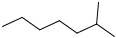

In [61]:
irc1

In [62]:
irc2

In [63]:
p1

In [64]:
p2

In [68]:
mol = AutoTST_Molecule("CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)C[C@@H]([C@]3(C(=O)[C@@H]2OC(=O)C)C)O)OC(=O)C)OC(=O)c5ccccc5)(C[C@@H]1OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)O)(C)C")

In [69]:
mol.view_mol()